# Clustering Neighbourhoods in Toronto

In [8]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 94 kB 5.9 MB/s  eta 0:00:01
Libraries imported.


In [9]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 16.0 MB/s eta 0:00:01


In [10]:
!pip install geocoder

     |████████████████████████████████| 98 kB 8.5 MB/s  eta 0:00:01


### Get and clean Median Household Income data
This will be used as a proxy for cost of living in an area

In [69]:
income = pd.read_html('https://github.com/19919/Coursera_Capstone/blob/master/medianHouseholdIncCommaSep.csv')[0]

In [71]:
income = income.iloc[:,2:]

Downloading state abbreviations

In [40]:
abbrevs = pd.read_html('https://www.ssa.gov/international/coc-docs/states.html')[0]

In [72]:
income['name'] = income.apply(lambda x: x.Region+', '+x.State, axis = 1)

In [58]:
latLong = {}
for address in income.name.values:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    try:
        latLong[address] = {'latitude' : location.latitude, 
                            'longitude' : location.longitude}
    except:
        latLong[address] = {'latitude' : '', 
                            'longitude' : ''}

In [88]:
income

,RegionCode,MedianIncome,State,Region,name,latitude,longitude
0,45001,42758,SC,Abbeville County,"Abbeville County, SC",34.2265,-82.4364
1,22001,39822,LA,Acadia Parish,"Acadia Parish, LA",30.2741,-92.3957
2,51001,42417,VA,Accomack County,"Accomack County, VA",37.7422,-75.6744
3,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237
4,19001,51496,IA,Adair County,"Adair County, IA",41.3128,-94.4953
...,...,...,...,...,...,...,...
3134,4027,43733,AZ,Yuma County,"Yuma County, AZ",32.7915,-113.898
3135,8125,46807,CO,Yuma County,"Yuma County, CO",40.0163,-102.458
3136,48505,31593,TX,Zapata County,"Zapata County, TX",26.988,-99.1674
3137,48507,28736,TX,Zavala County,"Zavala County, TX",28.8367,-99.7676


In [73]:
income = income.merge(pd.DataFrame(latLong).T.rename_axis('name').reset_index())

In [89]:
income = income[income.longitude != '']

In [90]:
income.to_pickle('income.pkl')

Getting very nice data from https://simplemaps.com/data/us-cities

In [80]:
!wget 'https://simplemaps.com/static/data/us-cities/1.73/basic/simplemaps_uscities_basicv1.73.zip'

--2021-02-22 20:44:53--  https://simplemaps.com/static/data/us-cities/1.73/basic/simplemaps_uscities_basicv1.73.zip
Resolving simplemaps.com (simplemaps.com)... 172.67.71.113, 104.26.12.95, 104.26.13.95, ...
Connecting to simplemaps.com (simplemaps.com)|172.67.71.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3855871 (3.7M) [application/zip]
Saving to: ‘simplemaps_uscities_basicv1.73.zip’

simplemaps_uscities 100%[===================>]   3.68M  12.3MB/s    in 0.3s    

2021-02-22 20:44:54 (12.3 MB/s) - ‘simplemaps_uscities_basicv1.73.zip’ saved [3855871/3855871]



In [82]:
!unzip simplemaps_uscities_basicv1.73.zip

Archive:  simplemaps_uscities_basicv1.73.zip
  inflating: license.txt             
  inflating: uscities.csv            
  inflating: uscities.xlsx           


In [84]:
details = pd.read_csv('uscities.csv')

In [93]:
cities = pd.merge(income, details, left_on = 'RegionCode', right_on = 'county_fips')

In [94]:
cities = cities[(cities.longitude < -115) & (cities.longitude > -125)]

In [98]:
grouped = cities.groupby('Region')

In [133]:
topCities = []
for citi in grouped.groups:
    topCities.append([x for x in grouped.get_group(citi).sort_values('population', ascending = False).head(3).index.values])

In [134]:
topCities = cities.loc[[item for sublist in topCities for item in sublist]]

In [135]:
topCities = topCities.reset_index(drop = True)

In [142]:
topCities.to_pickle('topCities.pkl')

In [144]:
topCities.to_csv('topCities.csv')

#### Create a map of Toronto with neighborhoods superimposed on top.


In [141]:
# create map of New York using latitude and longitude values
map_topCities = folium.Map(location=[40, -117], zoom_start=5)

# add markers to map
for lat, lng, size, city in zip(topCities['lat'], topCities['lng'], topCities['population'], topCities['city']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/300000,
        popup=city,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_topCities)  
    
map_topCities

## Q3

#### Define Foursquare Credentials and Version


In [145]:
CLIENT_ID = '5KGOSG104PVEOSMCFU415AOVYU4URTXXTF3THPCIOBVEUEG4' # your Foursquare ID
CLIENT_SECRET = 'B3YL4YXJGIRBTP32WXQHYFI2CCM4NAHKVDK2NO1D5MKDDJ0I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 400 # A default Foursquare API limit value


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5KGOSG104PVEOSMCFU415AOVYU4URTXXTF3THPCIOBVEUEG4
CLIENT_SECRET:B3YL4YXJGIRBTP32WXQHYFI2CCM4NAHKVDK2NO1D5MKDDJ0I


In [146]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
us_venues = getNearbyVenues(names=topCities['city'],
                                   latitudes=topCities['lat'],
                                   longitudes=topCities['lng'])


Boise
Meridian
Eagle
Council
New Meadows
Oakland
Fremont
Hayward
Mesa Vista
Markleeville
Alpine Village
Ione
Jackson
Sutter Creek
Clarkston
Clarkston Heights-Vineland
West Clarkston-Highland
Baker City
Huntington
Haines
St. Maries
Plummer
De Smet
Corvallis
Philomath
Adair Village
Robie Creek
Horseshoe Bend
Garden Valley
Sandpoint
Priest River
Ponderay
Bonners Ferry
Moyie Springs
Chico
Oroville
Magalia
Rancho Calaveras
Copperopolis
Angels
Nampa
Caldwell
Middleton
Carson City
Wenatchee
Chelan
Cashmere
Fallon
Fallon Station
Lake Oswego
Oregon City
West Linn
Port Angeles
Sequim
Forks
Las Vegas
Henderson
North Las Vegas
Astoria
Seaside
Warrenton
Orofino
Pierce
Weippe
St. Helens
Scappoose
Dayton
Colusa
Williams
Arbuckle
Concord
Antioch
Richmond
Coos Bay
North Bend
Coquille
Longview
Kelso
Woodland
Prineville
Brookings
Gold Beach
Harbor
Crescent City
Bertsch-Oceanview
Fort Dick
Bend
Redmond
Deschutes River Woods
Roseburg
East Wenatchee
Gardnerville Ranchos
El Dorado Hills
Placerville
South Lak

#### Let's check the size of the resulting dataframe


In [149]:
us_venues.to_pickle('venues.pkl')

## 3. Analyze Each Neighborhood


In [154]:
# one hot encoding
us_onehot = pd.get_dummies(us_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
us_onehot['city'] = us_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [us_onehot.columns[-1]] + list(us_onehot.columns[:-1])
us_onehot = us_onehot[fixed_columns]

us_onehot.head()

,city,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Boise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Boise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Boise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [155]:
us_onehot.shape

(8213, 417)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [157]:
us_grouped = us_onehot.groupby('city').mean().reset_index()
us_grouped

,city,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Aberdeen,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adair Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Albany,0.000000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Allyn,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alta Sierra,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,Yakima,0.000000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,Yellow Pine,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408,Yosemite Valley,0.000000,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,Yreka,0.058824,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size


In [158]:
us_grouped.shape

(411, 417)

In [168]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [178]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['city'] = us_grouped['city']

for ind in np.arange(us_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aberdeen,Fast Food Restaurant,Coffee Shop,Thrift / Vintage Store,Historic Site,Grocery Store,Mexican Restaurant,Sandwich Place,Pizza Place,Convenience Store,Department Store
1,Adair Village,Disc Golf,Café,Trail,Convenience Store,Food Stand,Food Service,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant
2,Albany,Convenience Store,Pizza Place,Coffee Shop,Gas Station,Ice Cream Shop,Asian Restaurant,Bus Stop,Gym,Gym / Fitness Center,Seafood Restaurant
3,Allyn,Playground,Mexican Restaurant,Golf Course,Convenience Store,Burger Joint,Food,American Restaurant,Coffee Shop,Gas Station,Yoga Studio
4,Alta Sierra,Construction & Landscaping,Print Shop,Astrologer,Yoga Studio,Fire Station,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant


<a id='item4'></a>


## 4. Cluster Neighborhoods


Check how many clusters that is optimal


In [179]:
us_grouped_clustering = us_grouped.drop('city', 1)

In [180]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [181]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(us_grouped.drop('city', 1))

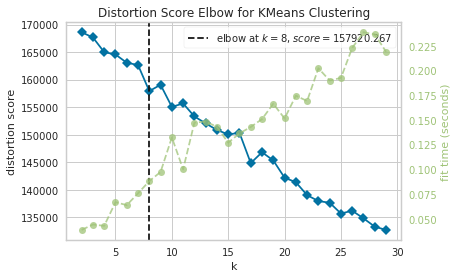

In [182]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X)        # Fit data to visualizer
visualizer.show()

### small elbow @17 clusters --> will use that as K

In [183]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [184]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

us_merged = topCities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
us_merged = us_merged.join(neighbourhoods_venues_sorted.set_index('city'), on='city')

us_merged.head() # check the last columns!

,RegionCode,MedianIncome,State,Region,name,latitude,longitude,city,city_ascii,state_id,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Boise,Boise,ID,...,Park,Furniture / Home Store,Smoke Shop,Coffee Shop,Arts & Crafts Store,Gas Station,Escape Room,French Restaurant,Jewelry Store,Fast Food Restaurant
1,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Meridian,Meridian,ID,...,Pizza Place,Bar,Burger Joint,Gas Station,Coffee Shop,Thrift / Vintage Store,Business Service,Sandwich Place,Restaurant,Pub
2,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Eagle,Eagle,ID,...,Construction & Landscaping,Yoga Studio,Fish & Chips Shop,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
3,16003,44722,ID,Adams County,"Adams County, ID",44.8677,-116.457,Council,Council,ID,...,ATM,Gas Station,Pizza Place,Convenience Store,Food Service,Financial or Legal Service,Event Space,Eye Doctor,Fabric Shop,Factory
4,16003,44722,ID,Adams County,"Adams County, ID",44.8677,-116.457,New Meadows,New Meadows,ID,...,Discount Store,Grocery Store,Sandwich Place,Fast Food Restaurant,Pizza Place,Yoga Studio,Event Space,Eye Doctor,Fabric Shop,Factory


Finally, let's visualize the resulting clusters


In [188]:
us_merged

,RegionCode,MedianIncome,State,Region,name,latitude,longitude,city,city_ascii,state_id,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Boise,Boise,ID,...,Park,Furniture / Home Store,Smoke Shop,Coffee Shop,Arts & Crafts Store,Gas Station,Escape Room,French Restaurant,Jewelry Store,Fast Food Restaurant
1,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Meridian,Meridian,ID,...,Pizza Place,Bar,Burger Joint,Gas Station,Coffee Shop,Thrift / Vintage Store,Business Service,Sandwich Place,Restaurant,Pub
2,16001,69224,ID,Ada County,"Ada County, ID",43.4137,-116.237,Eagle,Eagle,ID,...,Construction & Landscaping,Yoga Studio,Fish & Chips Shop,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
3,16003,44722,ID,Adams County,"Adams County, ID",44.8677,-116.457,Council,Council,ID,...,ATM,Gas Station,Pizza Place,Convenience Store,Food Service,Financial or Legal Service,Event Space,Eye Doctor,Fabric Shop,Factory
4,16003,44722,ID,Adams County,"Adams County, ID",44.8677,-116.457,New Meadows,New Meadows,ID,...,Discount Store,Grocery Store,Sandwich Place,Fast Food Restaurant,Pizza Place,Yoga Studio,Event Space,Eye Doctor,Fabric Shop,Factory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,6113,67005,CA,Yolo County,"Yolo County, CA",38.7185,-121.906,Woodland,Woodland,CA,...,Hotel,Pizza Place,Grocery Store,Fast Food Restaurant,Gas Station,Park,Coffee Shop,Sandwich Place,Café,Garden Center
443,6113,67005,CA,Yolo County,"Yolo County, CA",38.7185,-121.906,West Sacramento,West Sacramento,CA,...,Park,Fast Food Restaurant,Shopping Plaza,Café,Pizza Place,Salon / Barbershop,Yoga Studio,Event Space,Eye Doctor,Fabric Shop
444,6115,53088,CA,Yuba County,"Yuba County, CA",39.284,-121.356,Linda,Linda,CA,...,Convenience Store,Electronics Store,Seafood Restaurant,Gas Station,Theater,Financial or Legal Service,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant
445,6115,53088,CA,Yuba County,"Yuba County, CA",39.284,-121.356,Olivehurst,Olivehurst,CA,...,Park,Video Store,Convenience Store,Mexican Restaurant,Event Service,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant


In [185]:
# create map
map_clusters = folium.Map(location=[40, -117], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(us_merged['lat'], us_merged['lng'], us_merged['city'], us_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float

<a id='item5'></a>


In [186]:
us_merged['Cluster Labels'].value_counts()

4.0    401
1.0     12
0.0      2
2.0      1
7.0      1
6.0      1
3.0      1
5.0      1
Name: Cluster Labels, dtype: int64

# Analysis

#### Seems like there are two main groups. I show below that Cluster 2 is more restaurant heavy whereas Cluster 1 is probably more residentially focused.

## 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 0


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,East Toronto,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood


#### Cluster 1
Even though there are a lot of restaurants,  it feels more like a residential cluster with coffee shops, stores and yoga studios.


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Park,Bakery,Restaurant,Pub,Breakfast Spot,Theater,Café,Electronics Store,Performing Arts Venue
1,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Fried Chicken Joint,Burger Joint,Burrito Place,Restaurant,Café,Smoothie Shop,Japanese Restaurant
2,Downtown Toronto,1,Coffee Shop,Clothing Store,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Lingerie Store,Ramen Restaurant
4,East Toronto,1,Neighborhood,Health Food Store,Trail,Pub,Yoga Studio,Dog Run,Diner,Discount Store,Distribution Center,Donut Shop
7,Downtown Toronto,1,Grocery Store,Café,Park,Baby Store,Restaurant,Candy Store,Nightclub,Coffee Shop,Italian Restaurant,Donut Shop
9,West Toronto,1,Bakery,Pharmacy,Liquor Store,Recording Studio,Bank,Supermarket,Brewery,Middle Eastern Restaurant,Pool,Café
12,East Toronto,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Indian Restaurant,Spa,Juice Bar
14,West Toronto,1,Café,Breakfast Spot,Nightclub,Coffee Shop,Pet Store,Furniture / Home Store,Burrito Place,Restaurant,Stadium,Italian Restaurant
15,East Toronto,1,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Movie Theater,Italian Restaurant,Fish & Chips Shop,Brewery,Ice Cream Shop,Pub,Restaurant
18,Central Toronto,1,Park,Construction & Landscaping,Bus Line,Swim School,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 2
Looks like there's mostly restaurants, bars and pubs in this cluster.


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,2,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Department Store,Moroccan Restaurant,Lingerie Store,Clothing Store,Gym
5,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant,Seafood Restaurant,Beer Bar,Farmers Market,Greek Restaurant,Fish Market
6,Downtown Toronto,2,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place,Bubble Tea Shop,Portuguese Restaurant,Ramen Restaurant,Poke Place
8,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Bakery,Thai Restaurant,Deli / Bodega,Steakhouse,Sushi Restaurant
11,West Toronto,2,Bar,Restaurant,Vegetarian / Vegan Restaurant,Café,Bakery,Men's Store,Asian Restaurant,Yoga Studio,Cuban Restaurant,Brewery
13,Downtown Toronto,2,Coffee Shop,Hotel,Café,Japanese Restaurant,American Restaurant,Italian Restaurant,Salad Place,Seafood Restaurant,Restaurant,Bakery
16,Downtown Toronto,2,Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant,Deli / Bodega
34,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Beer Bar,Café,Restaurant,Gym
36,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,Steakhouse,American Restaurant,Salad Place
